## 1 - Importing Datasets

In the code cell below, we import a dataset of images of drivers' activities while driving.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `activity_classes` - list of string-valued activity classes for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split

# define function to load the dataset
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 10)
    return files, targets

# load dataset
files, targets = load_dataset('train')

# split the dataset into a training set and a testing set
train_files, testing_files, train_targets, testing_targets = train_test_split(\
                            files, targets, test_size=0.2, random_state=42)

# split the testing dataset into a training set and a validating set
test_files, valid_files, test_targets, valid_targets = train_test_split(\
                            testing_files, testing_targets, test_size=0.5, random_state=42)

# load list of activities classes
activity_classes = [item[6:8] for item in sorted(glob("train/*/"))]

# print statistics about the dataset
print('There are %d total activity classes.' % len(activity_classes))
print('There are %s total driver images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training driver images.' % len(train_files))
print('There are %d validation driver images.' % len(valid_files))
print('There are %d test driver images.'% len(test_files))

Using TensorFlow backend.


There are 10 total activity classes.
There are 22424 total driver images.

There are 17939 training driver images.
There are 2243 validation driver images.
There are 2242 test driver images.


## 2 - Data exploration
Here we explore the training dataset get a simple description of the data and checking the classes distribution.

In [5]:
import pandas as pd

df = pd.read_csv("driver_imgs_list.csv")

# discribiting the class distribution among the train images
image_count = df['classname'].value_counts(sort=True)

print(df.head(5),'\n',)
print(df.describe(),'\n')
print(image_count)

  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg 

       subject classname           img
count    22424     22424         22424
unique      26        10         22424
top       p021        c0  img_6874.jpg
freq      1237      2489             1 

c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: classname, dtype: int64


## 3 - Data visualization
In the code cells below we visualize the class distribution and display a sample of the training images

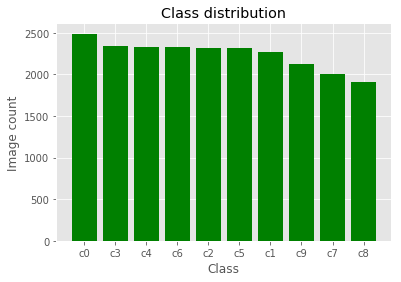

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# visualize the class distribution
plt.style.use('ggplot')
labels = image_count.index.tolist()
x_pos = [i for i, _ in enumerate(labels)]
plt.bar(x_pos, image_count, color='green')
plt.xlabel('Class')
plt.ylabel('Image count')
plt.title('Class distribution')
plt.xticks(x_pos, labels)
plt.show()

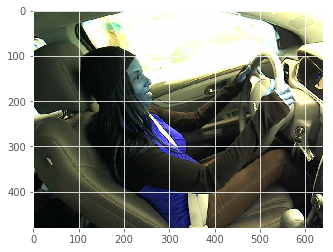

In [7]:
import cv2   

# display a sample image
img = cv2.imread(train_files[0])
plt.imshow(img)
plt.show()

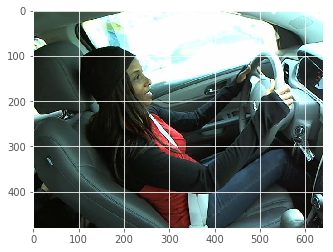

In [8]:
# convert image colors from BGR to RGB
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb)
plt.show()

## 4 - Data pre-processing
Since we are using keras with tensorflow as backend, keras CNN requires the inputs to be 4D tensors. Here we define a function `path_to_tensor` to take a string valued file path to an image and returns a 4D tensor of shape (N, 244, 244, 3) where N is the number of file paths. The tensors then are scaled by dividing each image by 255.

In [9]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [10]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True 

train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 2242/2242 [00:10<00:00, 210.81it/s]


## 5 - Benchmark model
Our benchmark model for this project is a simple CNN model comprises 3 convolutional layers with 3 maxpooling layers after each convolutional layer followed by a regularizing dropout layer and a flattening layer then a dense layer and another dropout layer and finally a dense layer with 10 outputs corresponding to the number of classes.

In [11]:
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=train_tensors.shape[1:])) 
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(80, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(len(activity_classes), activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)        0         
__________

### 5.1 - Compile & train the model

In [22]:
from keras.callbacks import ModelCheckpoint  

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 32
epochs = 4

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.benchmark.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

Train on 17939 samples, validate on 2243 samples
Epoch 1/4
17939/17939 [==============================] - 652s - loss: 0.9911 - acc: 0.6650 - val_loss: 0.0913 - val_acc: 0.9737
Epoch 2/4
17939/17939 [==============================] - 725s - loss: 0.2606 - acc: 0.9145 - val_loss: 0.0506 - val_acc: 0.9889
Epoch 3/4
17939/17939 [==============================] - 610s - loss: 0.1917 - acc: 0.9417 - val_loss: 0.0446 - val_acc: 0.9884
Epoch 4/4
17939/17939 [==============================] - 610s - loss: 0.1736 - acc: 0.9470 - val_loss: 0.0422 - val_acc: 0.9893


### 5.2 - Load & test the model with the best validation loss

In [27]:
from sklearn.metrics import log_loss

model.load_weights('saved_models/weights.best.benchmark.hdf5')

# get index of predicted driver's activity for each image in test set
driver_activity_predictions = np_utils.to_categorical([np.argmax(model.predict(np.expand_dims(tensor, axis=0)))\
                                                       for tensor in test_tensors], 10) 

# report test accuracy
test_logloss = log_loss(test_targets, driver_activity_predictions)
print('Test logarithmic loss: %.4f' % test_logloss)

Test logarithmic loss: 0.2157


## 6 - Initial solution

In [4]:
# import pre-trained model 
def extract_Xception(tensor):
    from keras.applications.xception import Xception, preprocess_input
    return Xception(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

# extract CNN codes
train_Xception = extract_Xception(train_tensors)
valid_Xception = extract_Xception(valid_tensors)
test_Xception = extract_Xception(test_tensors)

In [27]:
# save extracted CNN codes
np.save(open('Xception_tensors/Xception_train_tensors.npy', 'wb'), train_Xception)
np.save(open('Xception_tensors/Xception_valid_tensors.npy', 'wb'), valid_Xception)
np.save(open('Xception_tensors/Xception_test_tensors.npy', 'wb'), test_Xception)

In [15]:
# define a ConvNet model 
Xception_model = Sequential()
Xception_model.add(Dropout(0.3, input_shape=train_Xception.shape[1:]))
Xception_model.add(Flatten())
Xception_model.add(Dense(10, activation='softmax'))

Xception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_10 (Dropout)         (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1003530   
Total params: 1,003,530.0
Trainable params: 1,003,530.0
Non-trainable params: 0.0
_________________________________________________________________


In [16]:
# compile & train
Xception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

Xception_model.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=20, batch_size=16, callbacks=[checkpointer], verbose=1)

Train on 17939 samples, validate on 2243 samples
Epoch 1/20
17939/17939 [==============================] - 33s - loss: 1.7695 - acc: 0.3832 - val_loss: 1.9699 - val_acc: 0.3558
Epoch 2/20
17939/17939 [==============================] - 28s - loss: 1.1706 - acc: 0.5869 - val_loss: 1.0313 - val_acc: 0.6019
Epoch 3/20
17939/17939 [==============================] - 28s - loss: 0.9286 - acc: 0.6781 - val_loss: 1.7257 - val_acc: 0.4699
Epoch 4/20
17939/17939 [==============================] - 28s - loss: 0.7815 - acc: 0.7363 - val_loss: 0.8043 - val_acc: 0.7004
Epoch 5/20
17939/17939 [==============================] - 28s - loss: 0.6873 - acc: 0.7672 - val_loss: 0.7477 - val_acc: 0.7392
Epoch 6/20
17939/17939 [==============================] - 28s - loss: 0.6252 - acc: 0.7898 - val_loss: 0.5835 - val_acc: 0.8007
Epoch 7/20
17939/17939 [==============================] - 28s - loss: 0.5747 - acc: 0.8096 - val_loss: 0.6392 - val_acc: 0.7593
Epoch 8/20
17939/17939 [==============================]

In [23]:
# load best weights
Xception_model.load_weights('saved_models/weights.best.Xception.hdf5')

# get index of predicted driver's activity for each image in test set
Xception_model_predictions = np_utils.to_categorical([np.argmax(Xception_model.predict(np.expand_dims(tensor, axis=0)))\
                                                       for tensor in test_Xception], 10) 

# report test accuracy
Xception_model_test_logloss = log_loss(test_targets, Xception_model_predictions)
print('Test logarithmic loss: %.4f' % Xception_model_test_logloss)

Test logarithmic loss: 1.2632


## 7 - Refined solution 1

In [9]:
# define ConvNet model
Xception_model_2 = Sequential()
Xception_model_2.add(Dropout(0.3, input_shape=train_Xception.shape[1:]))
Xception_model_2.add(Flatten())
Xception_model_2.add(Dense(250, activation='relu'))
Xception_model_2.add(Dropout(0.4))
Xception_model_2.add(Dense(10, activation='softmax'))

Xception_model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_4 (Dropout)          (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 250)               25088250  
_________________________________________________________________
dropout_5 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2510      
Total params: 25,090,760.0
Trainable params: 25,090,760.0
Non-trainable params: 0.0
_________________________________________________________________


In [ ]:
# compile & train
Xception_model_2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception2.hdf5', 
                               verbose=1, save_best_only=True)

Xception_model_2.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=20, batch_size=16, callbacks=[checkpointer], verbose=1)

Train on 17939 samples, validate on 2243 samples
Epoch 1/20
17939/17939 [==============================] - 404s - loss: 2.3136 - acc: 0.1086 - val_loss: 2.2995 - val_acc: 0.1119
Epoch 2/20
17939/17939 [==============================] - 408s - loss: 2.3003 - acc: 0.1106 - val_loss: 2.2990 - val_acc: 0.1119
Epoch 3/20
17939/17939 [==============================] - 408s - loss: 2.3002 - acc: 0.1106 - val_loss: 2.2987 - val_acc: 0.1119
Epoch 4/20
17939/17939 [==============================] - 409s - loss: 2.3002 - acc: 0.1106 - val_loss: 2.2986 - val_acc: 0.1119
Epoch 5/20
17939/17939 [==============================] - 406s - loss: 2.3002 - acc: 0.1106 - val_loss: 2.2986 - val_acc: 0.1119
Epoch 6/20
17939/17939 [==============================] - 406s - loss: 2.3002 - acc: 0.1106 - val_loss: 2.2986 - val_acc: 0.1119
Epoch 7/20
17939/17939 [==============================] - 406s - loss: 2.3002 - acc: 0.1106 - val_loss: 2.2986 - val_acc: 0.1119
Epoch 9/20
17939/17939 [========================

In [24]:
# load best weights
Xception_model_2.load_weights('saved_models/weights.best.Xception2.hdf5')

# get index of predicted driver's activity for each image in test set
Xception_model_2_predictions = np_utils.to_categorical([np.argmax(Xception_model_2.predict(np.expand_dims(tensor, axis=0)))\
                                                       for tensor in test_Xception], 10) 

# report test accuracy
Xception_model_2_test_logloss = log_loss(test_targets, Xception_model_2_predictions)
print('Test logarithmic loss: %.4f' % Xception_model_2_test_logloss)

Test logarithmic loss: 30.6258


## 8 - Refined solution 2

In [3]:
# load the CNN codes
train_Xception = np.load(open('Xception_tensors/Xception_train_tensors.npy', 'rb'))
valid_Xception = np.load(open('Xception_tensors/Xception_valid_tensors.npy', 'rb'))
test_Xception = np.load(open('Xception_tensors/Xception_test_tensors.npy', 'rb'))

In [12]:
from keras.applications.xception import Xception
from keras.models import Model

# define ConvNet model
base_model = Xception(weights='imagenet', include_top=False, input_shape = (224,224,3))

top_block = Sequential()
top_block.add(Dropout(0.3, input_shape=train_Xception.shape[1:]))
top_block.add(Flatten())
top_block.add(Dense(10, activation='softmax'))

Xception_model_3 = Model(inputs=base_model.input, outputs=top_block(base_model.output))

for layer in Xception_model_3.layers[:116]:
   layer.trainable = False
for layer in Xception_model_3.layers[116:]:
   layer.trainable = True

Xception_model_3.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
Xception_model_3.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 111, 111, 32)  864                                          
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 111, 111, 32)  128                                          
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 111, 111, 32)  0                                            
___________________________________________________________________________________________

In [61]:
# train the model
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception3.hdf5', 
                               verbose=1, save_best_only=True)

Xception_model_3.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=10, batch_size=64, callbacks=[checkpointer], verbose=1)

Train on 17939 samples, validate on 2243 samples
Epoch 1/10
17939/17939 [==============================] - 11381s - loss: 0.5778 - acc: 0.8014 - val_loss: 0.1828 - val_acc: 0.9541
Epoch 2/10
17939/17939 [==============================] - 11332s - loss: 0.0490 - acc: 0.9857 - val_loss: 0.1001 - val_acc: 0.9777
Epoch 3/10
17939/17939 [==============================] - 11341s - loss: 0.0527 - acc: 0.9877 - val_loss: 0.1456 - val_acc: 0.9643
Epoch 4/10
17939/17939 [==============================] - 11358s - loss: 0.0252 - acc: 0.9937 - val_loss: 0.1409 - val_acc: 0.9643
Epoch 5/10
17939/17939 [==============================] - 11372s - loss: 0.0278 - acc: 0.9934 - val_loss: 0.1078 - val_acc: 0.9773
Epoch 6/10
17939/17939 [==============================] - 11363s - loss: 0.0445 - acc: 0.9894 - val_loss: 0.0936 - val_acc: 0.9826
Epoch 7/10
17939/17939 [==============================] - 11350s - loss: 0.0274 - acc: 0.9942 - val_loss: 0.0343 - val_acc: 0.9938
Epoch 8/10
17939/17939 [==========

In [17]:
# load best weights
Xception_model_3.load_weights('saved_models/weights.best.Xception3.hdf5')

# get index of predicted driver's activity for each image in test set
Xception_model_3_predictions = np_utils.to_categorical([np.argmax(Xception_model_3.predict(np.expand_dims(tensor, axis=0)))\
                                                       for tensor in test_tensors], 10) 

# report test accuracy
Xception_model_3_test_logloss = log_loss(test_targets, Xception_model_3_predictions)
print('Test logarithmic loss: %.4f' % Xception_model_3_test_logloss)

Test logarithmic loss: 0.1541


## 9 - Testing the algorithm

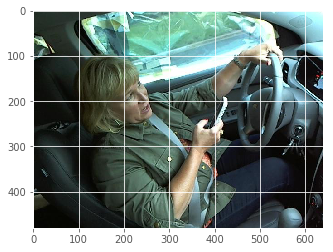

The driver is distracted 



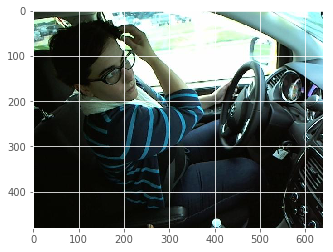

The driver is distracted 



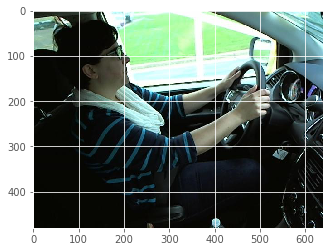

The driver is driving safely 



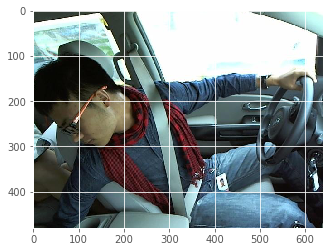

The driver is distracted 



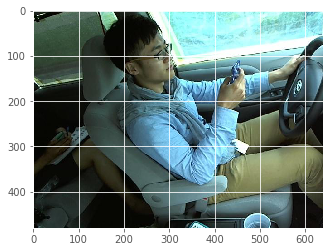

The driver is distracted 



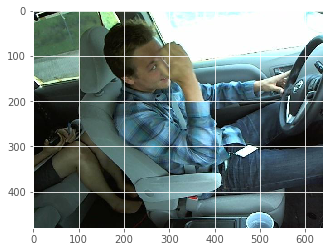

The driver is distracted 



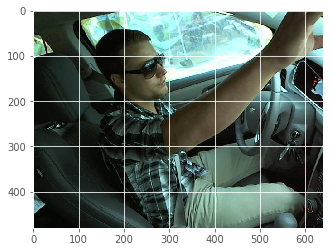

The driver is distracted 



In [28]:
# get image class prediction
def XceptionV3_predict_activity(img_path):
    img_tensor = path_to_tensor(img_path).astype('float32')/255
    predicted_vector = Xception_model_3.predict(img_tensor)
    return activity_classes[np.argmax(predicted_vector)]

# examine drivers' images
def examine_img(img_path):  
    if XceptionV3_predict_activity(img_path) == 'c0':
        plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
        plt.show()
        print('The driver is driving safely \n')
    else:
        plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
        plt.show()
        print('The driver is distracted \n')
        
# test the algorithm on 5 random images from the test files
testing_images = np.random.choice(test_files, 7)

for img in testing_images:
    examine_img(img)